In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv("../../../../estsoft/data/train.csv")

# Fill Nan

In [3]:
def fill_null(df:pd.DataFrame, time_before:list, time:list, time_after:list):
    df_fill = pd.DataFrame()
    for i in range(len(time_before)):
        df_null = df[df['datetime']==time[i]]
        df_concat = pd.concat([df[df['datetime']==time_before[i]], df[df['datetime']==time_after[i]]])

        # null값의 앞뒤 시간의 평균값 계산 및 저장
        ab_mean = pd.DataFrame(df_concat.groupby(['prediction_unit_id'])['target'].sum()/2).reset_index()
        df_merge = pd.merge(df_null, ab_mean, how='left', on='prediction_unit_id').drop(columns='target_x').rename(columns={'target_y':'target'})
        df_fill = pd.concat([df_fill, df_merge])

        # null값이 있는 행 drop
        df = df.drop(df_null.index)

    df = pd.concat([df, df_fill]).reset_index(drop=True).sort_values(by='datetime')
    return df

In [4]:
df_prod =df[df['is_consumption']==0]
df_cons = df[df['is_consumption']==1]

time_before = ['2022-10-30 02:00:00', '2022-03-27 02:00:00', '2023-03-26 02:00:00', '2021-10-31 02:00:00']
time = ['2022-10-30 03:00:00', '2022-03-27 03:00:00', '2023-03-26 03:00:00', '2021-10-31 03:00:00']
time_after = ['2022-10-30 04:00:00', '2022-03-27 04:00:00', '2023-03-26 04:00:00', '2021-10-31 04:00:00']

df_prod = fill_null(df_prod, time_before, time, time_after)
df_cons = fill_null(df_cons, time_before, time, time_after)

In [5]:
df_prod

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
33,8,1,3,0.000,0,2021-09-01 00:00:00,0,66,33
34,9,0,1,0.000,0,2021-09-01 00:00:00,0,68,34
35,9,0,3,0.089,0,2021-09-01 00:00:00,0,70,35
36,9,1,1,0.000,0,2021-09-01 00:00:00,0,72,36
...,...,...,...,...,...,...,...,...,...
1008879,7,1,1,0.000,0,2023-05-31 23:00:00,637,2018286,29
1008880,7,1,3,1.450,0,2023-05-31 23:00:00,637,2018288,30
1008881,8,0,1,0.108,0,2023-05-31 23:00:00,637,2018290,31
1008867,4,1,0,0.000,0,2023-05-31 23:00:00,637,2018262,17


In [6]:
df_prod['datetime'] = pd.to_datetime(df_prod['datetime'])
print(df_prod.info())
df_prod.set_index('datetime', drop=True, inplace=True) 

<class 'pandas.core.frame.DataFrame'>
Index: 1009176 entries, 0 to 1008853
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   county              1009176 non-null  int64         
 1   is_business         1009176 non-null  int64         
 2   product_type        1009176 non-null  int64         
 3   target              1009176 non-null  float64       
 4   is_consumption      1009176 non-null  int64         
 5   datetime            1009176 non-null  datetime64[ns]
 6   data_block_id       1009176 non-null  int64         
 7   row_id              1009176 non-null  int64         
 8   prediction_unit_id  1009176 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 77.0 MB
None


In [7]:
df_cons['datetime'] = pd.to_datetime(df_cons['datetime'])
print(df_cons.info())
df_cons.set_index('datetime', drop=True, inplace=True) 

<class 'pandas.core.frame.DataFrame'>
Index: 1009176 entries, 0 to 1008853
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   county              1009176 non-null  int64         
 1   is_business         1009176 non-null  int64         
 2   product_type        1009176 non-null  int64         
 3   target              1009176 non-null  float64       
 4   is_consumption      1009176 non-null  int64         
 5   datetime            1009176 non-null  datetime64[ns]
 6   data_block_id       1009176 non-null  int64         
 7   row_id              1009176 non-null  int64         
 8   prediction_unit_id  1009176 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 77.0 MB
None


In [8]:
df0 = df_prod[df_prod['prediction_unit_id']==0]
df0 = df0[['target']]
df0.index.freq = pd.infer_freq(df0.index)

# Check Stationary

In [9]:
def test_stationary(timeseries, column_name):

  dftest = adfuller(timeseries[column_name], autolag="AIC")
  dfoutput = pd.Series(dftest[0:4], index=['Test_statistic', 'p-value', '#lags-used', 'number_of_obs used'])

  for key, value in dftest[4].items():
    dfoutput['critical value(%s)' %key]=value

  print(dfoutput)

  movingavg = timeseries.rolling(window=24).mean()
  movingstd = timeseries.rolling(window=24).std()
  plt.figure()
  plt.plot(timeseries, label='time series')
  plt.figure()
  plt.plot(movingavg, label='r.mean')
  plt.figure()
  plt.plot(movingstd, label='r.std')

Test_statistic            -4.318336
p-value                    0.000413
#lags-used                43.000000
number_of_obs used     15268.000000
critical value(1%)        -3.430778
critical value(5%)        -2.861729
critical value(10%)       -2.566871
dtype: float64


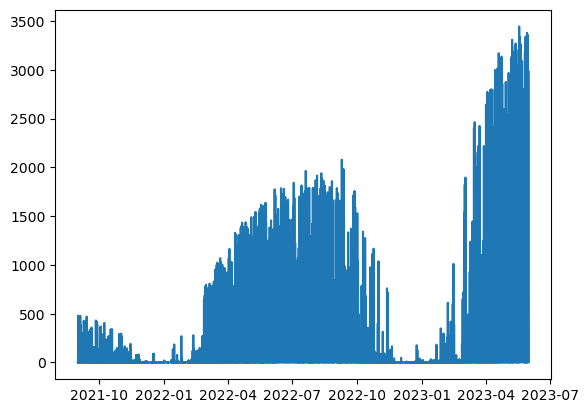

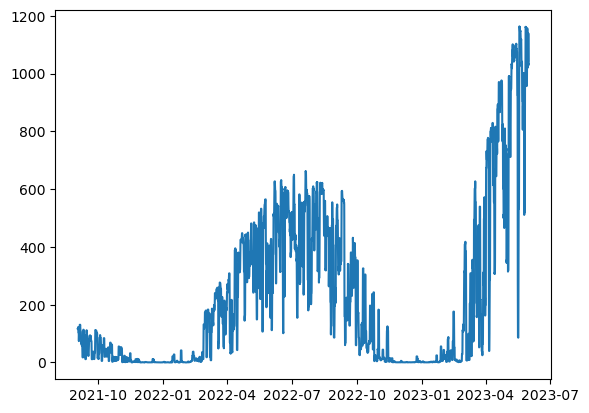

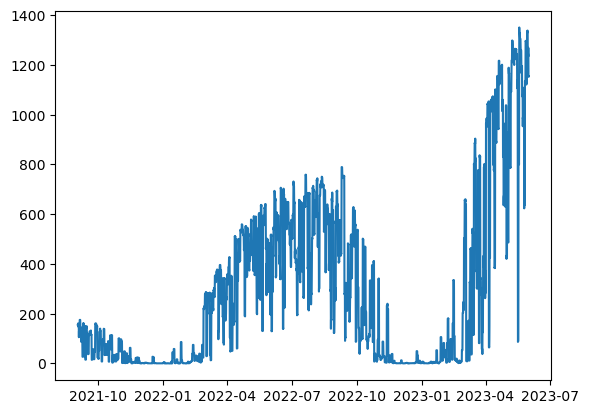

In [10]:
test_stationary(df0, 'target')

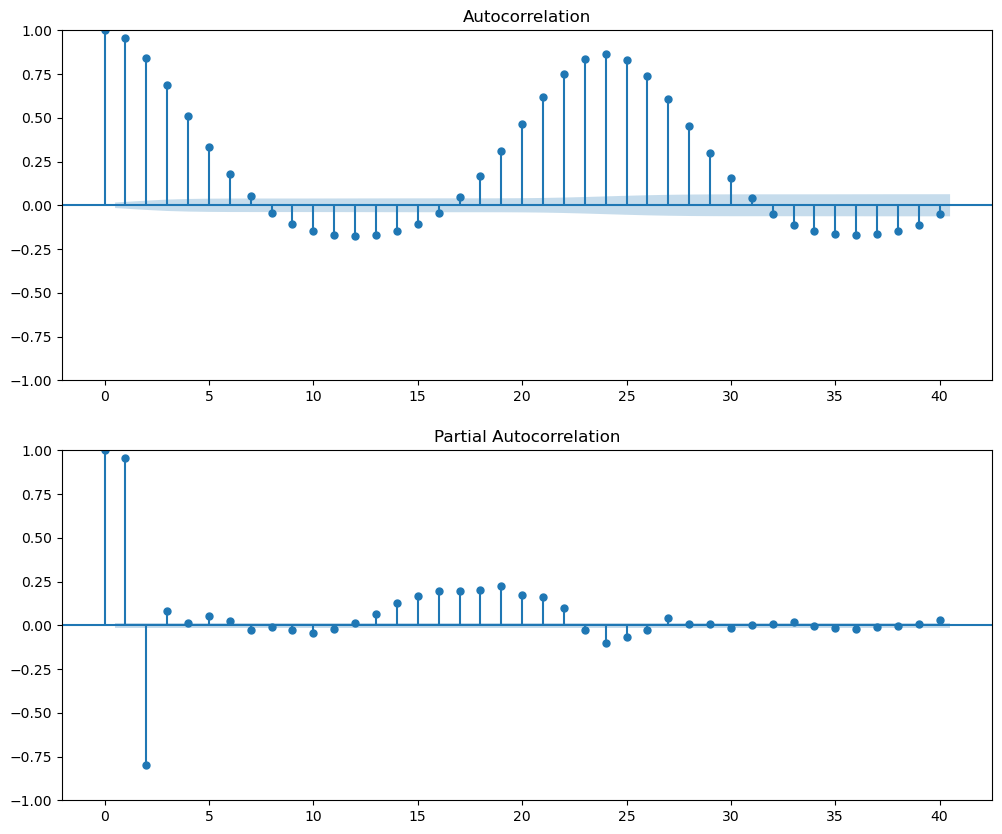

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
fig = plot_acf(df0['target'].squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df0['target'].squeeze(), lags=40, ax=ax2)

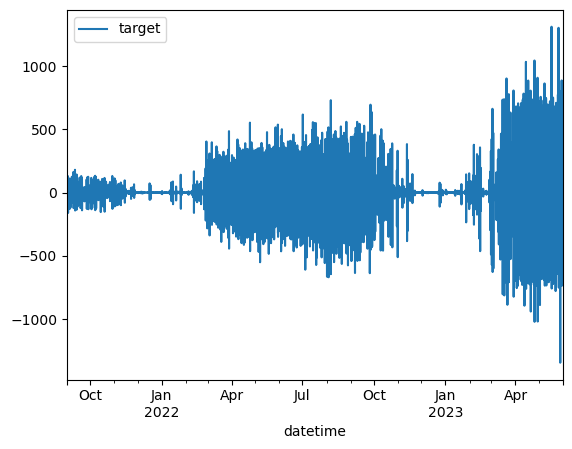

In [12]:
df0.diff(1).plot()
plt.show()

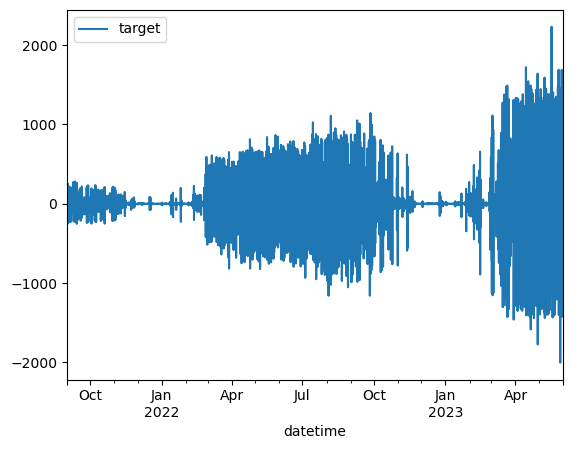

In [13]:
df0.diff(2).plot()
plt.show()

In [14]:
df0_diff1 = df0.diff(1).dropna()

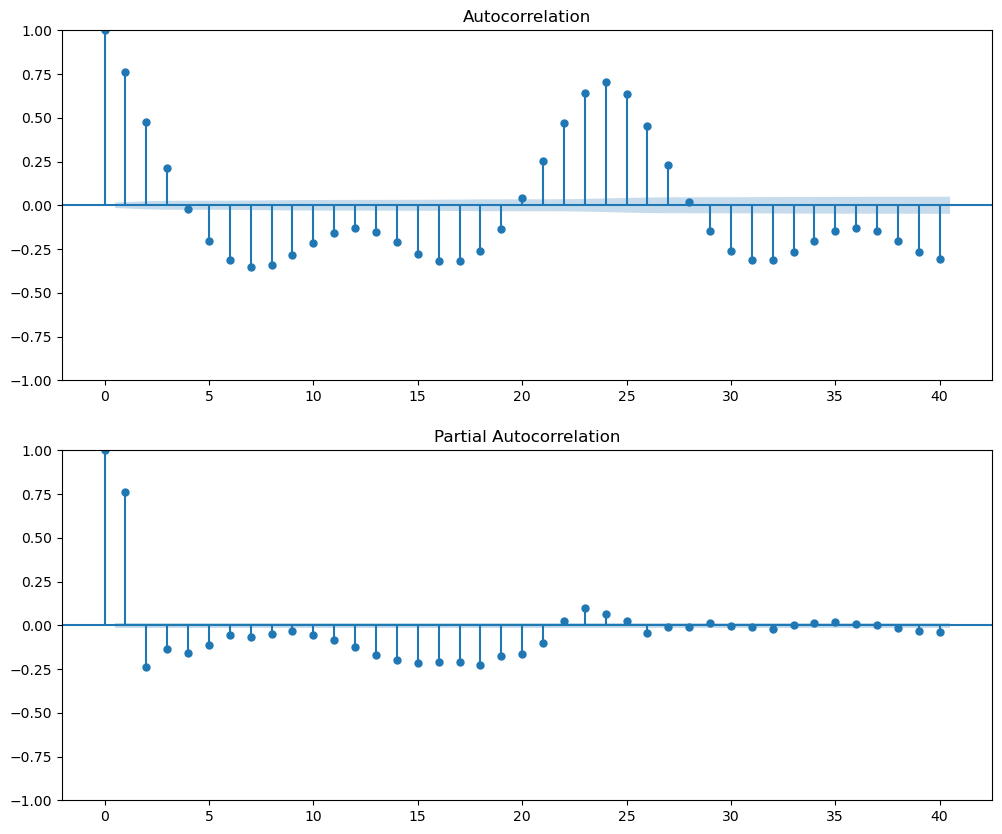

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
fig = plot_acf(df0_diff1['target'].squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df0_diff1['target'].squeeze(), lags=40, ax=ax2)

# ARIMA

In [16]:
from statsmodels.tsa.arima.model import ARIMA

In [17]:
def mape(y_pred, y_true):
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()

In [18]:
tst_size = 96
trn, tst = df0.target[:-tst_size], df0.target[-tst_size:]

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'arima(21,1,3), MAPE:1809.3876, MAE:309.5574, r2:0.8969')

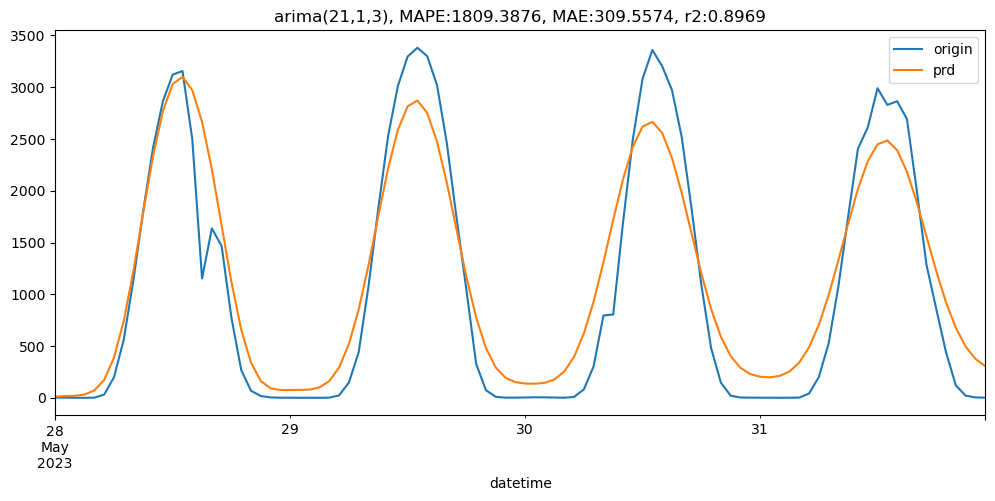

In [20]:
arima_21_1_3 = ARIMA(trn, order=(21, 1, 3)).fit()
prd = arima_21_1_3.predict('2023-05-28 00:00:00', '2023-05-31 23:00:00')

plt.figure(figsize=(12,5))
tst.plot(label='origin')
prd.plot(label='prd')
plt.legend()
plt.title(f'arima(21,1,3), MAPE:{mape(prd, tst):.4f}, MAE:{mae(prd, tst):.4f}, r2:{r2_score(tst, prd):.4f}')

Text(0.5, 1.0, 'arima(21,1,0), MAPE:1312.9926, MAE:304.0675, r2:0.8955')

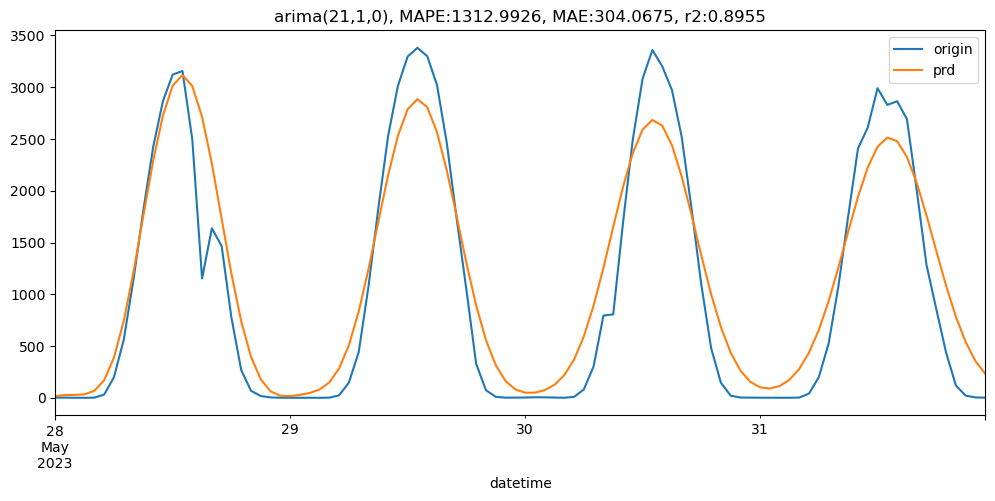

In [ ]:
arima_21_1_0 = ARIMA(trn, order=(21, 1, 0)).fit()
prd = arima_21_1_0.predict('2023-05-28 00:00:00', '2023-05-31 23:00:00')

plt.figure(figsize=(12,5))
tst.plot(label='origin')
prd.plot(label='prd')
plt.legend()
plt.title(f'arima(21,1,0), MAPE:{mape(prd, tst):.4f}, MAE:{mae(prd, tst):.4f}, r2:{r2_score(tst, prd):.4f}')

Text(0.5, 1.0, 'arima(21,0,0), MAPE:782.4849, MAE:290.2053, r2:0.8770')

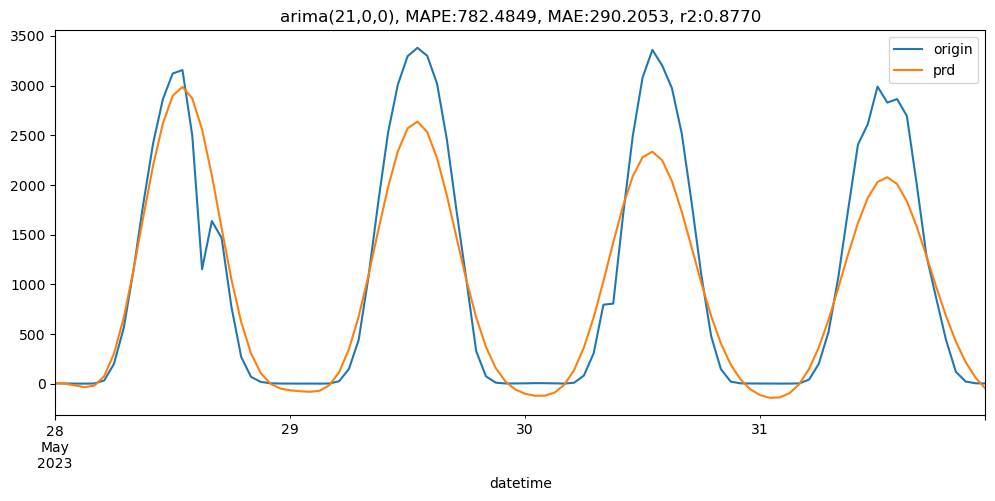

In [ ]:
arima_21_0_0 = ARIMA(trn, order=(21, 0, 0)).fit()
prd = arima_21_0_0.predict('2023-05-28 00:00:00', '2023-05-31 23:00:00')

plt.figure(figsize=(12,5))
tst.plot(label='origin')
prd.plot(label='prd')
plt.legend()
plt.title(f'arima(21,0,0), MAPE:{mape(prd, tst):.4f}, MAE:{mae(prd, tst):.4f}, r2:{r2_score(tst, prd):.4f}')

Text(0.5, 1.0, 'arima(22,0,0), MAPE:790.2505, MAE:280.1981, r2:0.8934')

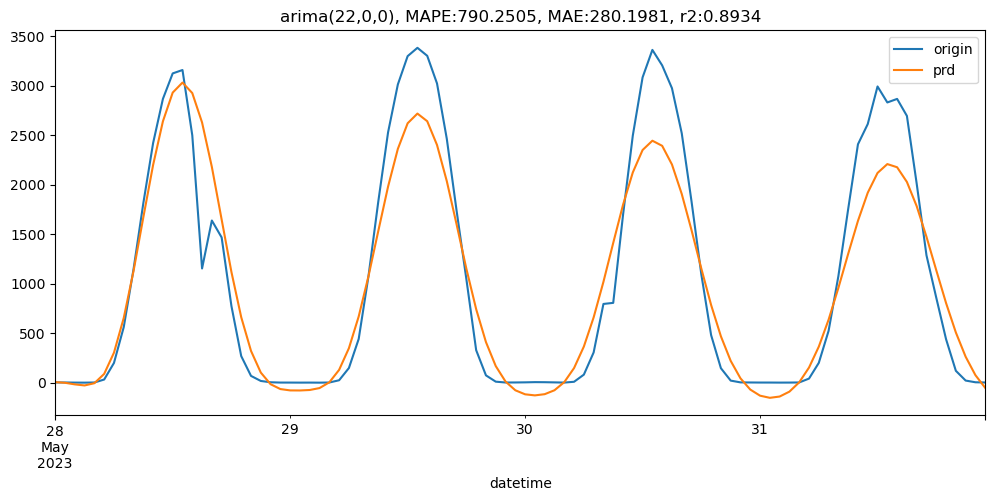

In [ ]:
arima_22_0_0 = ARIMA(trn, order=(22, 0, 0)).fit()
prd = arima_22_0_0.predict('2023-05-28 00:00:00', '2023-05-31 23:00:00')

plt.figure(figsize=(12,5))
tst.plot(label='origin')
prd.plot(label='prd')
plt.legend()
plt.title(f'arima(22,0,0), MAPE:{mape(prd, tst):.4f}, MAE:{mae(prd, tst):.4f}, r2:{r2_score(tst, prd):.4f}')

Text(0.5, 1.0, 'arima(24,0,0), MAPE:782.6245, MAE:272.1066, r2:0.8880')

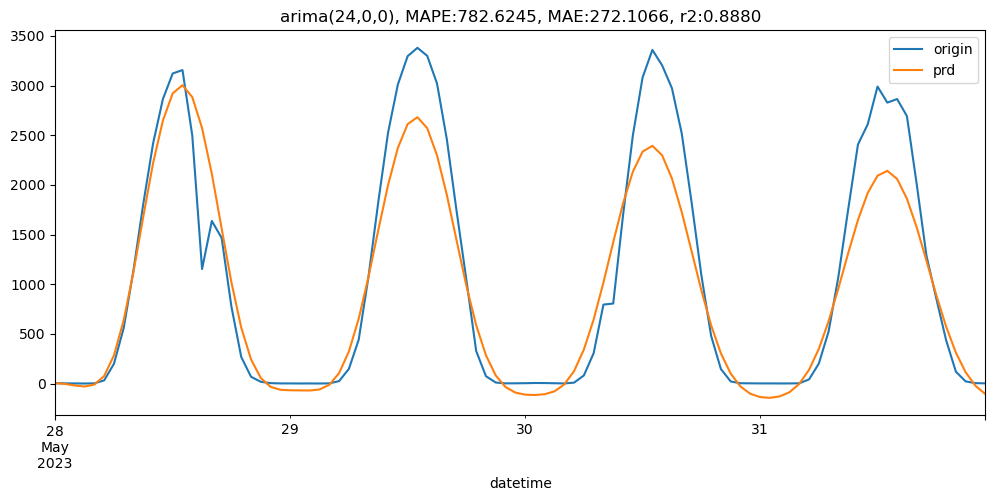

In [ ]:
arima_24_0_0 = ARIMA(trn, order=(24, 0, 0)).fit()
prd = arima_24_0_0.predict('2023-05-28 00:00:00', '2023-05-31 23:00:00')

plt.figure(figsize=(12,5))
tst.plot(label='origin')
prd.plot(label='prd')
plt.legend()
plt.title(f'arima(24,0,0), MAPE:{mape(prd, tst):.4f}, MAE:{mae(prd, tst):.4f}, r2:{r2_score(tst, prd):.4f}')

Text(0.5, 1.0, 'arima(27,0,0), MAPE:782.6245, MAE:272.1066, r2:0.8880')

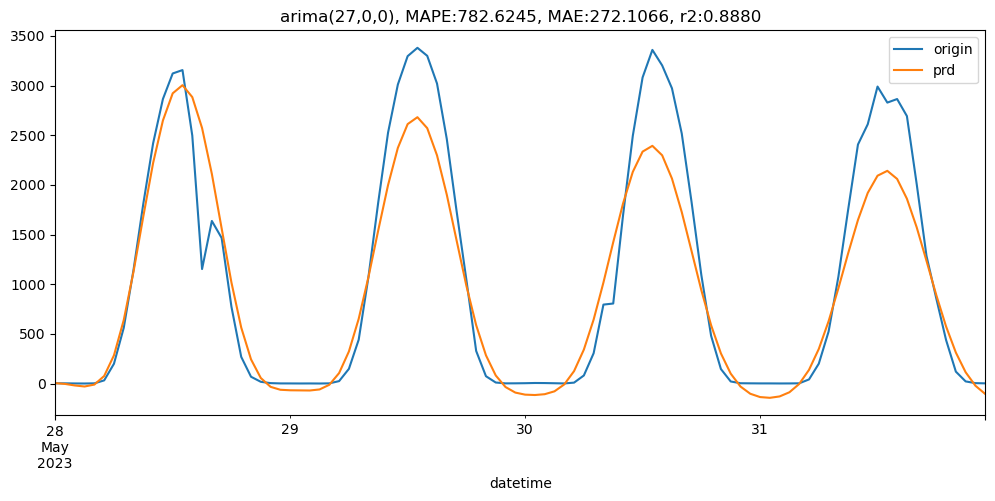

In [ ]:
arima_27_0_0 = ARIMA(trn, order=(27, 0, 0)).fit()
prd = arima_24_0_0.predict('2023-05-28 00:00:00', '2023-05-31 23:00:00')

plt.figure(figsize=(12,5))
tst.plot(label='origin')
prd.plot(label='prd')
plt.legend()
plt.title(f'arima(27,0,0), MAPE:{mape(prd, tst):.4f}, MAE:{mae(prd, tst):.4f}, r2:{r2_score(tst, prd):.4f}')

In [ ]:
prd

2023-05-28 00:00:00     16.228909
2023-05-28 01:00:00     26.162472
2023-05-28 02:00:00     30.882320
2023-05-28 03:00:00     41.114983
2023-05-28 04:00:00     78.702942
                          ...    
2023-05-31 19:00:00    870.696527
2023-05-31 20:00:00    617.801722
2023-05-31 21:00:00    437.757134
2023-05-31 22:00:00    325.626801
2023-05-31 23:00:00    267.513227
Freq: H, Name: predicted_mean, Length: 96, dtype: float64

# Auto ARIMA

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
auto_arima_model = auto_arima(trn, start_p=20, start_q=20,
                             max_p=25, max_q=25, seasonal=False, # sarima(seasonal=True)
                             d=1, D=1,
                             max_P=3, max_Q=3,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=195993.606, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=186452.567, Time=2.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=183308.671, Time=2.90 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=182208.791, Time=4.06 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=181623.193, Time=4.94 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=181527.985, Time=6.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=182737.095, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=182011.371, Time=2.79 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=181844.806, Time=4.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=181676.893, Time=6.43 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=10.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=181755.741, Time=0.75 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=7.61 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=7.75 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=12.48 sec
 ARIMA

In [ ]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                15216
Model:               SARIMAX(5, 1, 0)   Log Likelihood              -90455.576
Date:                Fri, 05 Jan 2024   AIC                         180925.152
Time:                        08:26:03   BIC                         180978.562
Sample:                    09-01-2021   HQIC                        180942.860
                         - 05-27-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0093      0.908      0.010      0.992      -1.771       1.790
ar.L1          0.8808      0.003    293.379      0.000       0.875       0.887
ar.L2         -0.1352      0.004    -38.324      0.000      -0.142      -0.128
ar.L3         -0.0125      0.004     -3.524      0.000      -0.019      -0.006
ar.L4         -0.0580      0.004    -13.009      0.000      -0.067      -0.049
ar.L5         -0.1068      0.004    -24.650      0.000      -0.115      -0.098
sigma2      8541.4686     31.782    268.755      0.000    8479.178    8603.759
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):            326487.17
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):              12.89   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred = auto_arima_model.predict(len(tst), return_conf_int=True)
pred_val = pred[0]
# mae = mae(tst.to_numpy(dtype=np.float32), pred_val.to_numpy(dtype=np.float32))

In [ ]:
pred_val

2023-05-28 00:00:00     85.409811
2023-05-28 01:00:00    199.734842
2023-05-28 02:00:00    304.051584
2023-05-28 03:00:00    381.408054
2023-05-28 04:00:00    429.289923
                          ...    
2023-05-31 19:00:00    331.305316
2023-05-31 20:00:00    331.326878
2023-05-31 21:00:00    331.348454
2023-05-31 22:00:00    331.370047
2023-05-31 23:00:00    331.391652
Freq: H, Length: 96, dtype: float64

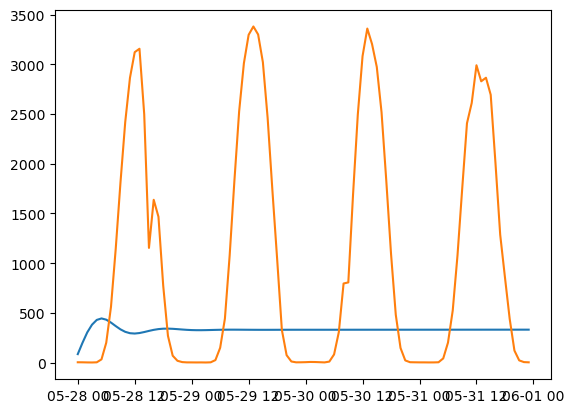

In [ ]:
plt.plot(pred_val)
plt.plot(tst)

# Submission

In [ ]:
submission = pd.read_csv('../../../../estsoft/data/example_test_files/sample_submission.csv')
submission

,row_id,data_block_id,target
0,2005872,634,0
1,2005873,634,0
2,2005874,634,0
3,2005875,634,0
4,2005876,634,0
...,...,...,...
12475,2018347,637,0
12476,2018348,637,0
12477,2018349,637,0
12478,2018350,637,0


In [ ]:
prd = prd.reset_index()
prd

,index,predicted_mean
0,2023-05-28 00:00:00,16.228909
1,2023-05-28 01:00:00,26.162472
2,2023-05-28 02:00:00,30.882320
3,2023-05-28 03:00:00,41.114983
4,2023-05-28 04:00:00,78.702942
...,...,...
91,2023-05-31 19:00:00,870.696527
92,2023-05-31 20:00:00,617.801722
93,2023-05-31 21:00:00,437.757134
94,2023-05-31 22:00:00,325.626801


In [ ]:
sub = df[(df['prediction_unit_id']==0)&(df['is_consumption']==0)][['row_id','datetime']]
sub = pd.to_datetime(sub['datetime'])
sub = sub.reset_index().rename(columns={'index':'row_id'})
sub

,row_id,datetime
0,0,2021-09-01 00:00:00
1,122,2021-09-01 01:00:00
2,244,2021-09-01 02:00:00
3,366,2021-09-01 03:00:00
4,488,2021-09-01 04:00:00
...,...,...
15307,2017702,2023-05-31 19:00:00
15308,2017832,2023-05-31 20:00:00
15309,2017962,2023-05-31 21:00:00
15310,2018092,2023-05-31 22:00:00


In [ ]:
sub_merge = pd.merge(prd, sub, how='inner', left_on='index', right_on='datetime').drop(columns=['index','datetime']).rename(columns={'predicted_mean':'target'})
sub_merge

,target,row_id
0,16.228909,2005872
1,26.162472,2006002
2,30.882320,2006132
3,41.114983,2006262
4,78.702942,2006392
...,...,...
91,870.696527,2017702
92,617.801722,2017832
93,437.757134,2017962
94,325.626801,2018092


In [ ]:
sub_final = pd.merge(submission, sub_merge, how='left', on='row_id').drop(columns='target_x').rename(columns={'target_y':'target'})
sub_final

,row_id,data_block_id,target
0,2005872,634,16.228909
1,2005873,634,NaN
2,2005874,634,NaN
3,2005875,634,NaN
4,2005876,634,NaN
...,...,...,...
12475,2018347,637,NaN
12476,2018348,637,NaN
12477,2018349,637,NaN
12478,2018350,637,NaN


In [ ]:
pd.set_option('display.max_rows', 10)
sub_final.head(500)

,row_id,data_block_id,target
0,2005872,634,16.228909
1,2005873,634,NaN
2,2005874,634,NaN
3,2005875,634,NaN
4,2005876,634,NaN
...,...,...,...
495,2006367,634,NaN
496,2006368,634,NaN
497,2006369,634,NaN
498,2006370,634,NaN


In [ ]:
(len(sub_final)-sub_final.isnull().sum()) == len(sub_merge)